### <font color='blue'>Spark MLLib - Clustering - K-Means</font>

In [1]:
spSession = SparkSession.builder.master("local").appName("SparkMLLib").config("spark.some.config.option", "session").getOrCreate()

In [2]:
import math
from pyspark.sql import Row
from pyspark.ml.linalg import Vectors
from pyspark.ml.clustering import KMeans
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline

In [3]:
# Loading the data and generating a RDD
carrosRDD = sc.textFile("carros2.csv")
carrosRDD.cache()
carrosRDD.count()

198

In [4]:
# Removing the first line of the file (header)
primeiraLinha = carrosRDD.first()
carrosRDD2 = carrosRDD.filter(lambda x: x != primeiraLinha)
carrosRDD2.count()

197

In [5]:
carrosRDD2.take(5)

['subaru,gas,std,two,hatchback,fwd,four,69,4900,31,36,5118',
 'chevrolet,gas,std,two,hatchback,fwd,three,48,5100,47,53,5151',
 'mazda,gas,std,two,hatchback,fwd,four,68,5000,30,31,5195',
 'toyota,gas,std,two,hatchback,fwd,four,62,4800,35,39,5348',
 'mitsubishi,gas,std,two,hatchback,fwd,four,68,5500,37,41,5389']

In [6]:
# Converting and cleaning the data
def transformToNumeric( inputStr) :
    attList = inputStr.split(",")

    doors = 1.0 if attList[3] == "two" else 2.0
    body = 1.0 if attList[4] == "sedan" else 2.0 
       
    linhas = Row(DOORS = doors, BODY = float(body), HP = float(attList[7]), RPM = float(attList[8]),
                 MPG = float(attList[9]))
    return linhas

In [7]:
# Applying the function 
carrosRDD3 = carrosRDD2.map(transformToNumeric)
carrosRDD3.persist()
carrosRDD3.take(5)

[Row(BODY=2.0, DOORS=1.0, HP=69.0, MPG=31.0, RPM=4900.0),
 Row(BODY=2.0, DOORS=1.0, HP=48.0, MPG=47.0, RPM=5100.0),
 Row(BODY=2.0, DOORS=1.0, HP=68.0, MPG=30.0, RPM=5000.0),
 Row(BODY=2.0, DOORS=1.0, HP=62.0, MPG=35.0, RPM=4800.0),
 Row(BODY=2.0, DOORS=1.0, HP=68.0, MPG=37.0, RPM=5500.0)]

In [8]:
# Creating a Dataframe
carrosDF = spSession.createDataFrame(carrosRDD3)
carrosDF.show()

+----+-----+----+----+------+
|BODY|DOORS|  HP| MPG|   RPM|
+----+-----+----+----+------+
| 2.0|  1.0|69.0|31.0|4900.0|
| 2.0|  1.0|48.0|47.0|5100.0|
| 2.0|  1.0|68.0|30.0|5000.0|
| 2.0|  1.0|62.0|35.0|4800.0|
| 2.0|  1.0|68.0|37.0|5500.0|
| 2.0|  1.0|60.0|38.0|5500.0|
| 1.0|  1.0|69.0|31.0|5200.0|
| 2.0|  1.0|68.0|37.0|5500.0|
| 2.0|  1.0|68.0|37.0|5500.0|
| 2.0|  1.0|68.0|31.0|5000.0|
| 2.0|  1.0|68.0|31.0|5500.0|
| 2.0|  2.0|68.0|31.0|5500.0|
| 2.0|  2.0|68.0|31.0|5500.0|
| 2.0|  1.0|70.0|38.0|5400.0|
| 2.0|  1.0|62.0|31.0|4800.0|
| 2.0|  1.0|68.0|31.0|5500.0|
| 2.0|  1.0|58.0|49.0|4800.0|
| 2.0|  2.0|62.0|31.0|4800.0|
| 2.0|  1.0|76.0|30.0|6000.0|
| 1.0|  2.0|70.0|38.0|5400.0|
+----+-----+----+----+------+
only showing top 20 rows



In [9]:
# Summarizing the data and extracting the mean and standard deviation
estats = carrosDF.describe().toPandas()
medias = estats.iloc[1,1:5].values.tolist()
desvios = estats.iloc[2,1:5].values.tolist()

In [10]:
# Placing the mean and standard deviation and variances of the Broadcast type
bc_media = sc.broadcast(medias)
bc_desvio = sc.broadcast(desvios)

In [11]:
# Function to centralize and scale the data. Each value will be subtracted from the mean then divided by the standard deviation
def centerAndScale(inRow) :
    global bc_media
    global bc_desvio
    
    meanArray = bc_media.value
    stdArray = bc_desvio.value

    retArray = []
    
    for i in range(len(meanArray)):
        retArray.append( (float(inRow[i]) - float(meanArray[i])) / float(stdArray[i]) )
    return Vectors.dense(retArray)

In [12]:
carrosRDD4 = carrosDF.rdd.map(centerAndScale)
carrosRDD4.collect()

[DenseVector([0.9337, -1.145, -0.9194, 0.9083]),
 DenseVector([0.9337, -1.145, -1.4773, 3.3936]),
 DenseVector([0.9337, -1.145, -0.9459, 0.753]),
 DenseVector([0.9337, -1.145, -1.1053, 1.5297]),
 DenseVector([0.9337, -1.145, -0.9459, 1.8403]),
 DenseVector([0.9337, -1.145, -1.1585, 1.9956]),
 DenseVector([-1.0656, -1.145, -0.9194, 0.9083]),
 DenseVector([0.9337, -1.145, -0.9459, 1.8403]),
 DenseVector([0.9337, -1.145, -0.9459, 1.8403]),
 DenseVector([0.9337, -1.145, -0.9459, 0.9083]),
 DenseVector([0.9337, -1.145, -0.9459, 0.9083]),
 DenseVector([0.9337, 0.869, -0.9459, 0.9083]),
 DenseVector([0.9337, 0.869, -0.9459, 0.9083]),
 DenseVector([0.9337, -1.145, -0.8928, 1.9956]),
 DenseVector([0.9337, -1.145, -1.1053, 0.9083]),
 DenseVector([0.9337, -1.145, -0.9459, 0.9083]),
 DenseVector([0.9337, -1.145, -1.2116, 3.7043]),
 DenseVector([0.9337, 0.869, -1.1053, 0.9083]),
 DenseVector([0.9337, -1.145, -0.7334, 0.753]),
 DenseVector([-1.0656, 0.869, -0.8928, 1.9956]),
 DenseVector([-1.0656, -

In [13]:
# Creating Dataframe
carrosRDD5 = carrosRDD4.map( lambda f:Row(features = f))
carrosDF = spSession.createDataFrame(carrosRDD5)
carrosDF.select("features").show(10)

+--------------------+
|            features|
+--------------------+
|[0.93367168148051...|
|[0.93367168148051...|
|[0.93367168148051...|
|[0.93367168148051...|
|[0.93367168148051...|
|[0.93367168148051...|
|[-1.0656035495158...|
|[0.93367168148051...|
|[0.93367168148051...|
|[0.93367168148051...|
+--------------------+
only showing top 10 rows



In [14]:
# Creating the model
kmeans = KMeans(k = 3, seed = 1)
modelo = kmeans.fit(carrosDF)

In [15]:
# Predictions
previsoes = modelo.transform(carrosDF)
previsoes.show()

+--------------------+----------+
|            features|prediction|
+--------------------+----------+
|[0.93367168148051...|         2|
|[0.93367168148051...|         2|
|[0.93367168148051...|         2|
|[0.93367168148051...|         2|
|[0.93367168148051...|         2|
|[0.93367168148051...|         2|
|[-1.0656035495158...|         2|
|[0.93367168148051...|         2|
|[0.93367168148051...|         2|
|[0.93367168148051...|         2|
|[0.93367168148051...|         2|
|[0.93367168148051...|         1|
|[0.93367168148051...|         1|
|[0.93367168148051...|         2|
|[0.93367168148051...|         2|
|[0.93367168148051...|         2|
|[0.93367168148051...|         2|
|[0.93367168148051...|         1|
|[0.93367168148051...|         2|
|[-1.0656035495158...|         1|
+--------------------+----------+
only showing top 20 rows



In [16]:
def unstripData(instr) :
    return (instr["prediction"], instr["features"][0], instr["features"][1], instr["features"][2], instr["features"][3])

In [17]:
carrosRDD6 = previsoes.rdd.map(unstripData)
predList = carrosRDD6.collect()
predPd = pd.DataFrame(predList)

In [18]:
predPd.head()

,0,1,2,3,4
0,2,0.933672,-1.144971,-0.919362,0.908332
1,2,0.933672,-1.144971,-1.477291,3.393629
2,2,0.933672,-1.144971,-0.945930,0.753001
3,2,0.933672,-1.144971,-1.105338,1.529656
4,2,0.933672,-1.144971,-0.945930,1.840318


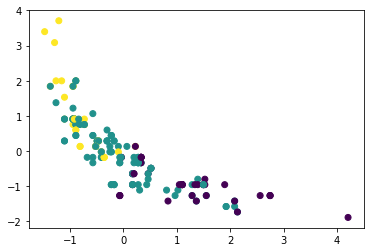

In [19]:
# Graph with the results of the created clusters
plt.cla()
plt.scatter(predPd[3], predPd[4], c=predPd[0])